# IMPORTS

In [1]:
import featuretools as ft

https://featuretools.alteryx.com/en/stable/getting_started/afe.html

# EntitySets
## First dataframe

In [2]:
data = ft.demo.load_mock_customer()
transactions_df = data["transactions"].merge(data["sessions"]).merge(data["customers"])

transactions_df.head()

,transaction_id,session_id,transaction_time,product_id,amount,customer_id,device,session_start,zip_code,join_date,birthday
0,298,1,2014-01-01 00:00:00,5,127.64,2,desktop,2014-01-01,13244,2012-04-15 23:31:04,1986-08-18
1,2,1,2014-01-01 00:01:05,2,109.48,2,desktop,2014-01-01,13244,2012-04-15 23:31:04,1986-08-18
2,308,1,2014-01-01 00:02:10,3,95.06,2,desktop,2014-01-01,13244,2012-04-15 23:31:04,1986-08-18
3,116,1,2014-01-01 00:03:15,4,78.92,2,desktop,2014-01-01,13244,2012-04-15 23:31:04,1986-08-18
4,371,1,2014-01-01 00:04:20,3,31.54,2,desktop,2014-01-01,13244,2012-04-15 23:31:04,1986-08-18


## Second dataframe

In [3]:
products_df = data["products"]
products_df

,product_id,brand
0,1,B
1,2,B
2,3,B
3,4,B
4,5,A


## Creating an EntitySet

In [4]:
es = ft.EntitySet(id="customer_data")

## Adding dataframes

In [6]:
from woodwork.logical_types import Categorical, PostalCode


es = es.add_dataframe(
    dataframe_name="transactions",
    dataframe=transactions_df,
    index="transaction_id", # The index parameter specifies the column that uniquely identifies rows in the dataframe
    time_index="transaction_time", # The time_index parameter tells Featuretools when the data was created.
    logical_types={ # The logical_types parameter indicates that “product_id” should be interpreted as a Categorical column, even though it is just an integer in the underlying data.
        "product_id": Categorical,
        "zip_code": PostalCode,
    },
)

es

Entityset: customer_data
  DataFrames:
    transactions [Rows: 500, Columns: 11]
  Relationships:
    No relationships

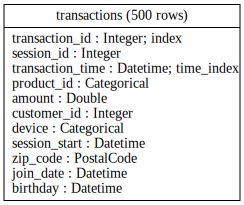

In [8]:
es.plot()

In [9]:
es["transactions"].ww.schema

,Logical Type,Semantic Tag(s)
Column,,
transaction_id,Integer,['index']
session_id,Integer,['numeric']
transaction_time,Datetime,['time_index']
product_id,Categorical,['category']
amount,Double,['numeric']
customer_id,Integer,['numeric']
device,Categorical,['category']
session_start,Datetime,[]
zip_code,PostalCode,['category']


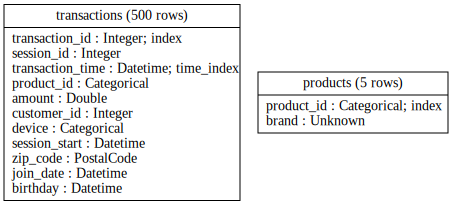

In [10]:
es = es.add_dataframe(
    dataframe_name="products",
    dataframe=products_df,
    index="product_id")

es.plot()

## Adding a Relationship

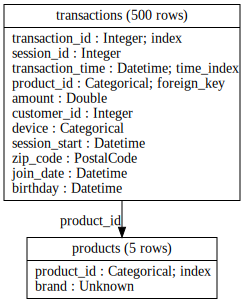

In [11]:
es = es.add_relationship("products", "product_id", "transactions", "product_id")
es.plot()

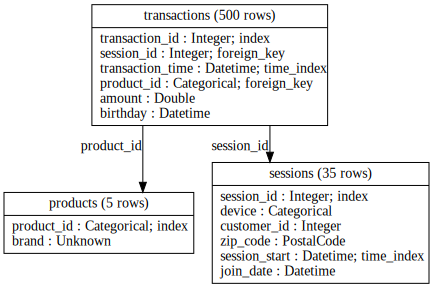

In [12]:
es = es.normalize_dataframe(
    base_dataframe_name="transactions",
    new_dataframe_name="sessions",
    index="session_id",
    make_time_index="session_start",
    additional_columns=[
        "device",
        "customer_id",
        "zip_code",
        "session_start",
        "join_date",
    ],
)
es.plot()

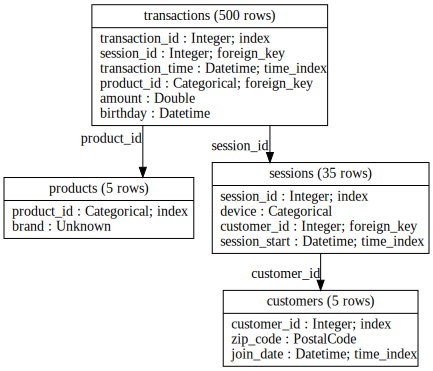

In [13]:
es = es.normalize_dataframe(
    base_dataframe_name="sessions",
    new_dataframe_name="customers",
    index="customer_id",
    make_time_index="join_date",
    additional_columns=["zip_code", "join_date"],
)

es.plot()

In [14]:
feature_matrix, feature_defs = ft.dfs(entityset=es, target_dataframe_name="products")

feature_matrix

,COUNT(transactions),MAX(transactions.amount),MEAN(transactions.amount),MIN(transactions.amount),SKEW(transactions.amount),STD(transactions.amount),SUM(transactions.amount),MODE(transactions.DAY(birthday)),MODE(transactions.DAY(transaction_time)),MODE(transactions.MONTH(birthday)),...,MODE(transactions.sessions.device),NUM_UNIQUE(transactions.DAY(birthday)),NUM_UNIQUE(transactions.DAY(transaction_time)),NUM_UNIQUE(transactions.MONTH(birthday)),NUM_UNIQUE(transactions.MONTH(transaction_time)),NUM_UNIQUE(transactions.WEEKDAY(birthday)),NUM_UNIQUE(transactions.WEEKDAY(transaction_time)),NUM_UNIQUE(transactions.YEAR(birthday)),NUM_UNIQUE(transactions.YEAR(transaction_time)),NUM_UNIQUE(transactions.sessions.device)
product_id,,,,,,,,,,,,,,,,,,,,,
1,102,149.56,73.429314,6.84,0.125525,42.479989,7489.79,18,1,7,...,desktop,4,1,3,1,4,1,5,1,3
2,92,149.95,76.319891,5.73,0.151934,46.336308,7021.43,18,1,8,...,desktop,4,1,3,1,4,1,5,1,3
3,96,148.31,73.001250,5.89,0.223938,38.871405,7008.12,18,1,8,...,desktop,4,1,3,1,4,1,5,1,3
4,106,146.46,76.311038,5.81,-0.132077,42.492501,8088.97,18,1,7,...,desktop,4,1,3,1,4,1,5,1,3
5,104,149.02,76.264904,5.91,0.098248,42.131902,7931.55,18,1,7,...,mobile,4,1,3,1,4,1,5,1,3
